In [218]:
# Importing library that handles requests and data from the URL
import requests 
import bs4 as bs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr, kendalltau
from sklearn import preprocessing
from statistics import mean
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures,  RobustScaler
from scipy.optimize import curve_fit
from scipy import stats
import seaborn as sns

# Let's get our data on the cases
df_cases = pd.read_csv("novel-corona-virus-2019-dataset/time_series_covid_19_confirmed_US.csv")

In [219]:
# Web scrape for weather information on the cities
months = ["february","march","april","may"]

la_url = 'https://www.accuweather.com/en/us/los-angeles/90012/may-weather/347625'
ny_url = 'https://www.accuweather.com/en/us/new-york/10007/may-weather/349727'
wayne_url = 'https://www.accuweather.com/en/us/wayne/48184/may-weather/338805'
philly_url = 'https://www.accuweather.com/en/us/philadelphia/19102/may-weather/350540'
hudson_url = 'https://www.accuweather.com/en/us/jersey-city/07306/may-weather/2-329548_1_al'

urls = la_url, ny_url, wayne_url, philly_url, hudson_url

la_weather = []
ny_weather = []
wayne_weather = []
philly_weather = []
hudson_weather = []

weather_info = la_weather, ny_weather, wayne_weather, philly_weather, hudson_weather
area = 0

for url in urls:
    weather = weather_info[area]
    month_place = 2
    
    for month in months:
        month_url = url.replace("may",month)
        text = requests.get(month_url, headers = {'User-Agent':'Mozilla/5.0'}).text
        soup = bs.BeautifulSoup(text, 'html.parser')
        days = soup.find_all("a", "monthly-daypanel is-past ")
        
        for day in days:
            info = []
            for date in day.find_all("div","date"):
                date = str((date.text).strip())
                full_date = f"{month_place}/{date}/2020"
                info.append(full_date)
            for high_temp in day.find_all("div","high"):
                info.append(int((high_temp.text).strip()[:-1]))
            
            for low_temp in day.find_all("div","low"):
                info.append(int((low_temp.text).strip()[:-1]))
            weather.append(info)
        month_place +=1
    area+=1
print('done!')

done!


In [220]:
# Example of what was done
# Get the high and low from february 5th
print(la_weather[10])

['2/5/2020', 64, 44]


In [221]:
# Get data on the cases from the csv
la = df_cases["UID"] == 84006037
ny = df_cases["UID"] == 84036061
wayne = df_cases["UID"] == 84026163
philly = df_cases["UID"] == 84042101
hudson = df_cases["UID"] == 84034017


In [222]:
# Transform to separate dataframes
la_cases = df_cases[la]
ny_cases = df_cases[ny]
wayne_cases = df_cases[wayne]
philly_cases = df_cases[philly]
hudson_cases = df_cases[hudson]

columns = ["Date","High Temp","Low Temp","Avg Temp","Cases"]

la_temp_cases = pd.DataFrame(columns = columns)
ny_temp_cases = pd.DataFrame(columns = columns)
wayne_temp_cases = pd.DataFrame(columns = columns)
philly_temp_cases = pd.DataFrame(columns = columns)
hudson_temp_cases = pd.DataFrame(columns = columns)

def create_dataframe(weather_list, cases_dataframe, new_dataframe):
    for info in weather_list:
        date = str(info[0])
        high_temp = float(info[1])
        low_temp = float(info[2])
        avg_temp = (high_temp+low_temp)/2
        if date in list(cases_dataframe.columns):
            new_dataframe = new_dataframe.append({"Date":date[:-5],
                                 "High Temp": high_temp,
                                 "Low Temp": low_temp,
                                "Avg Temp": avg_temp,
                                 "Cases": int(cases_dataframe[date])},
                                ignore_index = True)
    return new_dataframe



la_temp_cases = create_dataframe(la_weather,la_cases,la_temp_cases)
ny_temp_cases = create_dataframe(ny_weather,ny_cases,ny_temp_cases)
wayne_temp_cases = create_dataframe(wayne_weather,wayne_cases,wayne_temp_cases)
philly_temp_cases = create_dataframe(philly_weather,philly_cases,philly_temp_cases)
hudson_temp_cases = create_dataframe(hudson_weather,hudson_cases,hudson_temp_cases)

In [340]:
# To help you visualize what was done
# We have the date, high temp and the number of confirmed cases
hudson_temp_cases.head()

,Date,High Temp,Low Temp,Avg Temp,Cases
0,2/1,44.0,36.0,40.0,0
1,2/2,44.0,35.0,39.5,0
2,2/3,58.0,35.0,46.5,0
3,2/4,59.0,41.0,50.0,0
4,2/5,53.0,40.0,46.5,0


In [224]:
# Names are too long I can't do it haha
la_df = la_temp_cases
ny_df = ny_temp_cases
wayne_df = wayne_temp_cases
philly_df = philly_temp_cases
hudson_df = hudson_temp_cases

In [225]:
# Return a list of grow rates for the confirmed cases
def growth_rates(values):
    growth_rates = []
    for value in range(1,len(values)):
        previous = values[value-1]
        current = values[value]
        if previous ==0:
            growth_rate = 0
        else:
            difference = current-previous
            growth_rate = float((difference/previous)*100)
        growth_rates.append(growth_rate)
    return growth_rates

# Return average temperatures over a number of days
def average_by_days(values, days):
    increment = days
    averages = []
    
    while len(values[days:]) >= increment:
        total = 0
        for value in values[days-increment:days]:
            total += int(value)
            
        averages.append(float(total/increment))
        days += increment
        
        if len(values[days:])<increment and len(values[days:])!=0:
            total = 0
            for value in values[days:]:
                total+= int(value)
            averages.append(float(total/len(values[days:])))
    return averages    

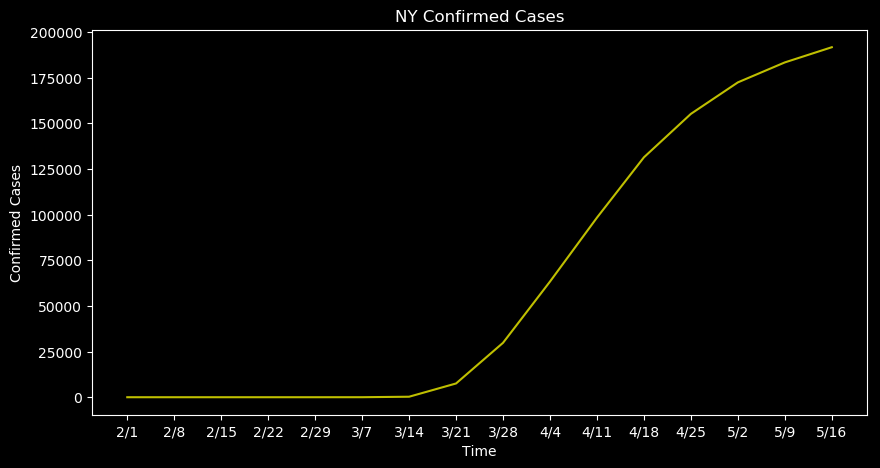

In [226]:
# Let's start to visualize the data
# Start with  ny 
dates = ny_df["Date"][::7]
cases = ny_df["Cases"][::7]

x = dates
y = cases

#plt.rcParams.update(plt.rcParamsDefault)
plt.style.use("dark_background")
plt.figure(figsize=(10,5))
plt.plot(x,y, color='y')
plt.xlabel("Time")
plt.ylabel("Confirmed Cases")
plt.title("NY Confirmed Cases")
plt.show()

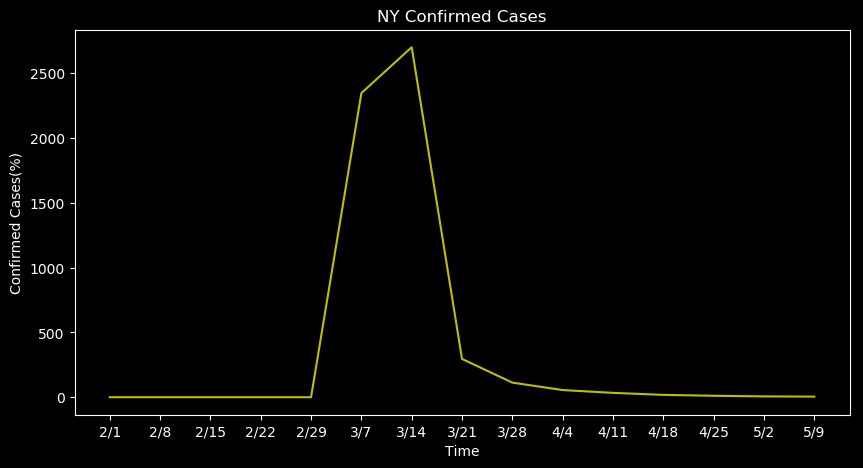

In [341]:
# Lets look at the change in growth for NY Confirmed cases
dates = ny_df["Date"][::7]
cases = ny_df["Cases"][::7]

x = dates[:-1]
y = growth_rates(np.asarray(cases))

plt.style.use("dark_background")

plt.figure(figsize=(10,5))
plt.plot(x,y, color='y')
plt.xlabel("Time")
plt.ylabel("Confirmed Cases(%)")
plt.title("NY Confirmed Cases")
plt.show()

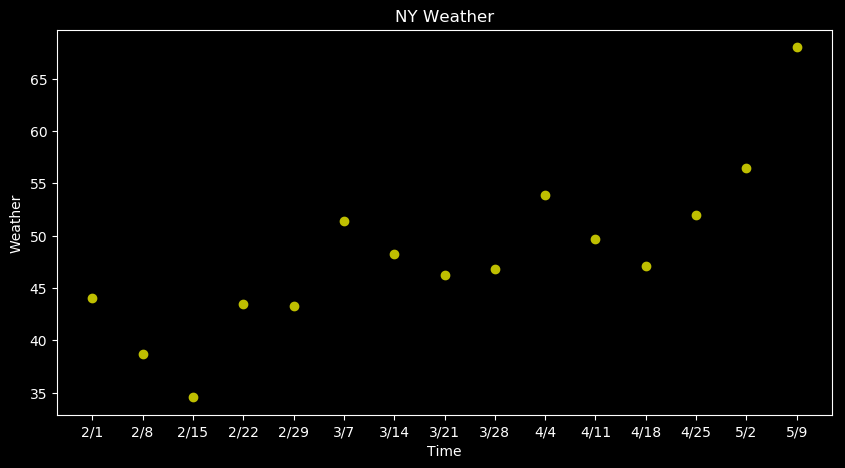

In [228]:
# Lets look at the change in growth for NY Confirmed cases
dates = ny_df["Date"][::7]
weather = ny_df["Avg Temp"]

x = dates[:-1]
y = average_by_days(list(weather), 7)



plt.figure(figsize=(10,5))
plt.scatter(x,y, color='y')
plt.xlabel("Time")
plt.ylabel("Weather")
plt.title("NY Weather")
plt.show()

In [229]:
# Creating a function to normalize data so we can put all the areas on one graph
def normalize_data(values):
    min_max_scaler = preprocessing.MinMaxScaler()
    x_values = min_max_scaler.fit_transform(values)
    return x_values

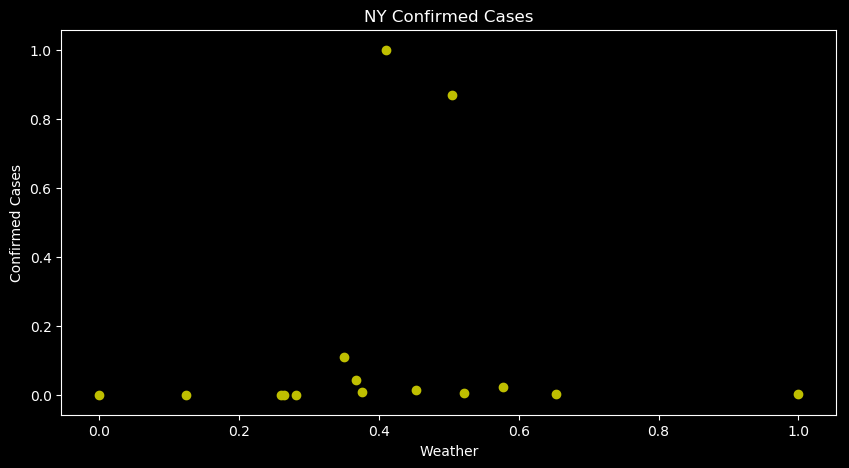

In [236]:
ny_weather = ny_df["Avg Temp"]
ny_cases = ny_df["Cases"][::7]
ny_y = growth_rates(np.asarray(cases))
ny_x = average_by_days(np.asarray(weather), 7)
ny_y = normalize_data(np.asarray(ny_y).reshape(-1,1))
ny_x = normalize_data(np.asarray(ny_x).reshape(-1,1))

plt.figure(figsize=(10,5))
plt.scatter(ny_x,ny_y, color='y')
plt.xlabel("Weather")
plt.ylabel("Confirmed Cases")
plt.title("NY Confirmed Cases")
plt.show()

In [237]:
# Create a function to make it easier to get our x and y values
# The time variable is a parameter give time between weeks
# Example: 1 means that temperatures of this week will affect next week
def get_values(dataframe,time_spread):

    weather = dataframe["Avg Temp"]
    cases = dataframe["Cases"][::7]    
    
    
    weather = weather[:len(weather)-time_spread]
    cases = cases[time_spread:]
    
    y = growth_rates(np.asarray(cases))
    x = average_by_days(np.asarray(weather),7)
    
    new_y = normalize_data(np.asarray(y).reshape(-1,1))
    new_x = normalize_data(np.asarray(x).reshape(-1,1))
    
    
    
    return new_x, new_y


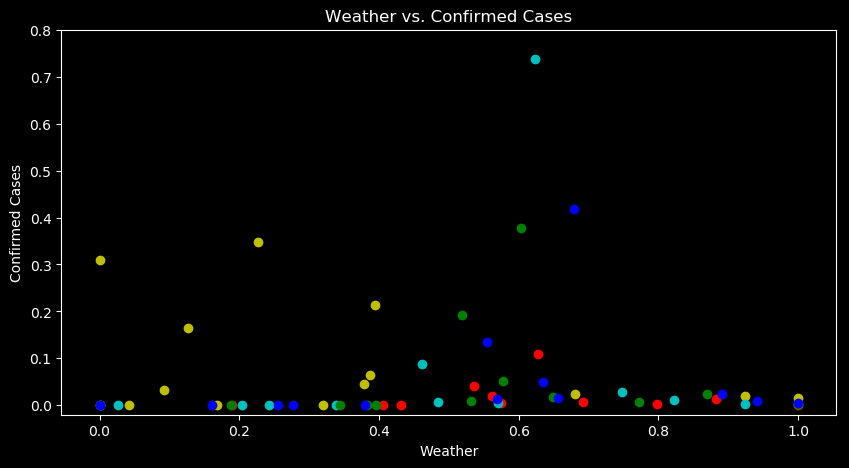

In [260]:
# Get values and use the 
time_spread = 1

ny_x, ny_y = get_values(ny_df,time_spread)
la_x, la_y = get_values(la_df,time_spread)
wayne_x, wayne_y = get_values(wayne_df,time_spread)
hudson_x, hudson_y = get_values(hudson_df,time_spread)
philly_x, philly_y = get_values(philly_df,time_spread)

plt.style.use("dark_background")
plt.figure(figsize=(10,5))
plt.scatter(ny_x,ny_y, color='r')
plt.scatter(la_x, la_y, color='y')
plt.scatter(wayne_x, wayne_y, color='c')
plt.scatter(hudson_x, hudson_y, color='g')
plt.scatter(philly_x, philly_y, color='b')
plt.ylim(-.02,.8)
plt.xlabel("Weather")
plt.ylabel("Confirmed Cases")
plt.title("Weather vs. Confirmed Cases")
plt.show()

In [271]:
# Creating an array of the xs and ys
ny_cases_data = np.concatenate((ny_x,ny_y),axis = 1)
la_cases_data = np.concatenate((la_x,la_y),axis = 1)
wayne_cases_data = np.concatenate((wayne_x,wayne_y),axis = 1)
hudson_cases_data = np.concatenate((hudson_x,hudson_y),axis = 1)
philly_cases_data = np.concatenate((philly_x,philly_y),axis = 1)

In [273]:
# To visualize what was just done
print(philly_cases_data)

[[0.37956204 0.        ]
 [0.16058394 0.        ]
 [0.         0.        ]
 [0.25547445 0.        ]
 [0.27737226 0.        ]
 [0.74452555 1.        ]
 [0.67883212 0.41713871]
 [0.55474453 0.1356026 ]
 [0.6350365  0.04948122]
 [0.89051095 0.02453555]
 [0.65693431 0.01568479]
 [0.56934307 0.01355457]
 [0.94160584 0.00895198]
 [1.         0.00476401]]


In [320]:
# As you can see above there's alot of 0s in the beginning because the cases are not confirmed
# We will only append once we've have seen initial growth in cases

datasets = (ny_cases_data, 'ny'),(la_cases_data, 'la'), (wayne_cases_data, 'wayne'), (hudson_cases_data, 'hudson'), (philly_cases_data, 'philly')

final_df = pd.DataFrame(columns = ["Weather", "Cases", "Area"])

for dataset in datasets:
    
    initial_growth = False
    row = 0
    
    while initial_growth == False:
        info = dataset[0][row]
        if info[1] != 0:
            initial_growth = True
        else:
            row+=1
    for data in dataset[0][row:]:
        weather = data[0]
        cases = data[1]
        area = dataset[1]
        final_df = final_df.append({"Weather":weather,
                                   "Cases":cases,
                                   "Area":area},
                                  ignore_index = True)
        

In [321]:
# Now we have a more efficient dataset
final_df.head()

,Weather,Cases,Area
0,0.398693,0.868926,ny
1,0.771242,1.000000,ny
2,0.627451,0.109449,ny
3,0.535948,0.041718,ny
4,0.562092,0.020483,ny


In [322]:
# Let's look at our data details
final_df.describe()

,Weather,Cases
count,48.000000,48.000000
mean,0.637800,0.198675
std,0.242272,0.329519
min,0.000000,0.001680
25%,0.517299,0.008781
50%,0.631244,0.026586
75%,0.803684,0.197371
max,1.000000,1.000000


In [323]:
# Removing the outliers from our initial spike
z_scores = stats.zscore(final_df.Cases)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 2)
new_df = final_df[filtered_entries]

In [342]:
# Score to show correlation
scorr, _ = spearmanr(new_df["Weather"],new_df["Cases"])

print(scorr)

-0.6089704636091255


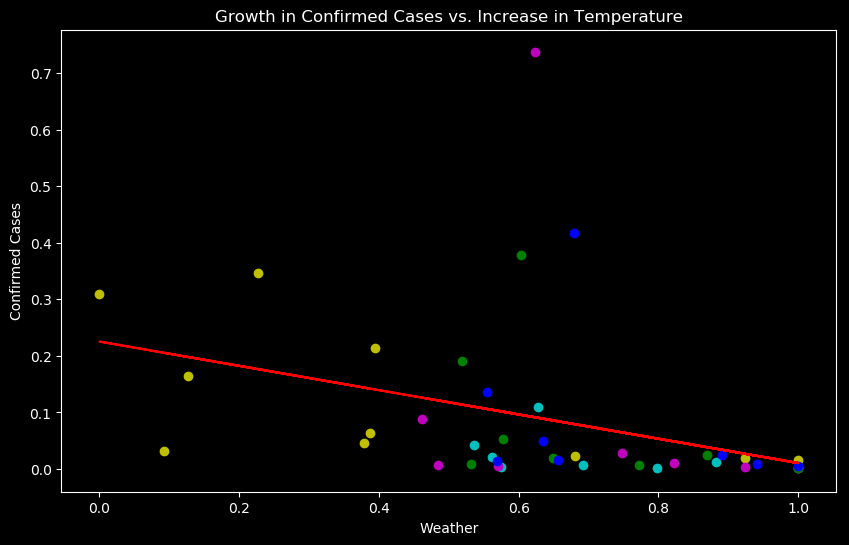

In [343]:
# Lets place the different areas on the graph
ny = new_df["Area"] == 'ny'
la = new_df["Area"] == 'la'
wayne = new_df["Area"] == 'wayne'
hudson = new_df["Area"] == 'hudson'
philly = new_df["Area"] == 'philly'

ny_x = new_df[ny]["Weather"]
ny_y = new_df[ny]["Cases"]

la_x = new_df[la]["Weather"]
la_y = new_df[la]["Cases"]

wayne_x = new_df[wayne]["Weather"]
wayne_y = new_df[wayne]["Cases"]

hudson_x = new_df[hudson]["Weather"]
hudson_y = new_df[hudson]["Cases"]

philly_x = new_df[philly]["Weather"]
philly_y = new_df[philly]["Cases"]

plt.figure(figsize=(10,6))

x = new_df["Weather"]
y = new_df["Cases"]

m, b = np.polyfit(x,y,1)
plt.plot(x, m*x+b,'r')

plt.scatter(ny_x,ny_y, color='c')
plt.scatter(la_x,la_y, color='y')
plt.scatter(wayne_x,wayne_y, color='m')
plt.scatter(hudson_x,hudson_y, color='g')
plt.scatter(philly_x,philly_y, color='b')
plt.xlabel("Weather")
plt.ylabel("Confirmed Cases")
plt.title("Growth in Confirmed Cases vs. Increase in Temperature")
plt.show()